Clustering

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# import arima model
from statsmodels.tsa.arima.model import ARIMA

In [3]:
data = pd.read_csv('data/preprocessed_and_cleaned_data.csv')
# Show index values
data.head()

,timestamp,city,temperature,humidity,windSpeed,pressure,dewPoint,demand_mwh,hour,day_of_week,month,season
0,2018-07-01 07:00:00,la,65.45,0.79,4.23,1014.5,58.64,9353.0,7,6,7,Summer
1,2018-07-01 07:00:00,phoenix,86.82,0.16,4.30,1008.9,34.57,2764.0,7,6,7,Summer
2,2018-07-01 07:00:00,san diego,61.71,0.80,3.53,1015.9,55.47,1737.0,7,6,7,Summer
3,2018-07-01 07:00:00,san jose,67.78,0.60,6.36,1012.8,53.27,10653.0,7,6,7,Summer
4,2018-07-01 07:00:00,seattle,59.32,0.86,4.81,1022.1,55.21,774.0,7,6,7,Summer


In [4]:
# Features for clustering
features = ['temperature', 'humidity', 'windSpeed', 'pressure', 'dewPoint', 'demand_mwh']
X = data[features]

# Apply RobustScaler (robust to outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

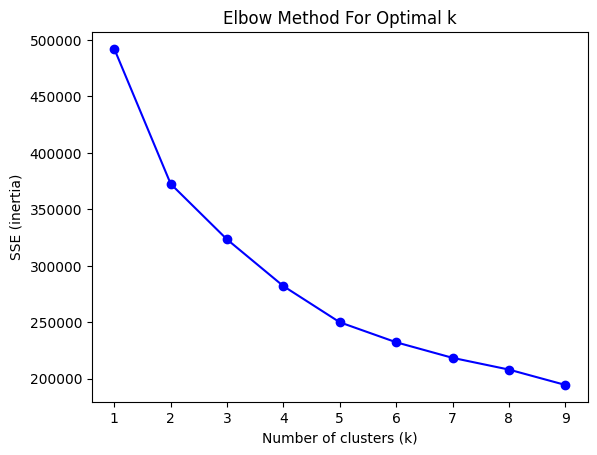

In [5]:
sse = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(K, sse, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()


In [6]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)


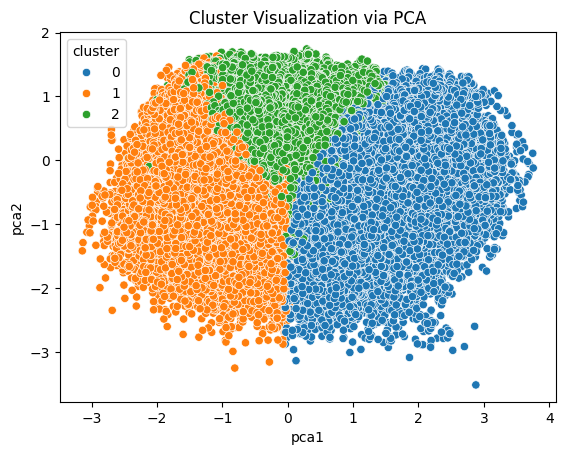

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

data['pca1'] = X_pca[:, 0]
data['pca2'] = X_pca[:, 1]

sns.scatterplot(data=data, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("Cluster Visualization via PCA")
plt.show()


In [8]:
clusters_un = data.groupby('cluster')[features + ['hour']].mean()
clusters_un

,temperature,humidity,windSpeed,pressure,dewPoint,demand_mwh,hour
cluster,,,,,,,
0,50.654100,0.557263,5.943817,1022.117886,32.955891,6422.085321,11.862458
1,79.785681,0.583986,7.269163,1012.801521,61.214149,10169.914966,12.711059
2,59.053417,0.778429,4.618596,1014.680460,51.547568,5565.034331,10.322249


In [9]:
label_map = {
    0: "Cool midday, moderate demand",
    1: "Hot afternoon, high demand",
    2: "Humid morning, low demand"
}
data['cluster_label'] = data['cluster'].map(label_map)

score = silhouette_score(X_scaled, data['cluster'])
print(f"Silhouette Score (k=3): {score:.4f}")

Silhouette Score (k=3): 0.1786


LSTM

In [42]:
data = pd.read_csv('data/preprocessed_and_cleaned_data.csv')
# Convert 'timestamp' to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
# Set 'timestamp' as index
data.set_index('timestamp', inplace=True)

In [43]:
data.columns

Index(['city', 'temperature', 'humidity', 'windSpeed', 'pressure', 'dewPoint',
       'demand_mwh', 'hour', 'day_of_week', 'month', 'season'],
      dtype='object')

In [46]:
# Apply LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Convert categorical variables to dummy variables
encoder = OneHotEncoder
cat_features = ['city', 'season']
encoded = encoder.fit_transform(data[cat_features])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_features))

# Drop original categorical features and concatenate encoded
data = data.drop(columns=cat_features)
data = pd.concat([data.reset_index(drop=True), encoded_df], axis=1)

# Scale numerical features
numerical_features = ['temperature', 'humidity', 'windSpeed', 'pressure', 'dewPoint', 'demand_mwh']
scaler = RobustScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Show the result
print(data.head())

   temperature  humidity  windSpeed  pressure  dewPoint  demand_mwh  hour  \
0     0.129995   0.31250  -0.180401 -0.150685  0.396648    0.404103     7   
1     1.111621  -1.65625  -0.164811 -0.917808 -0.723929   -0.440641     7   
2    -0.041801   0.34375  -0.336303  0.041096  0.249069   -0.572308     7   
3     0.237023  -0.28125   0.293987 -0.383562  0.146648    0.570769     7   
4    -0.151585   0.53125  -0.051225  0.890411  0.236965   -0.695769     7   

   day_of_week  month  city_dallas  ...  city_philadelphia  city_phoenix  \
0            6      7          0.0  ...                0.0           0.0   
1            6      7          0.0  ...                0.0           1.0   
2            6      7          0.0  ...                0.0           0.0   
3            6      7          0.0  ...                0.0           0.0   
4            6      7          0.0  ...                0.0           0.0   

   city_san antonio  city_san diego  city_san jose  city_seattle  season_Fall  \

In [48]:
X = data.drop(columns=['demand_mwh'], axis=1)
y = data['demand_mwh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

/home/muhammad/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - loss: 0.0250
Epoch 2/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - loss: 0.0179
Epoch 3/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - loss: 0.0174
Epoch 4/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - loss: 0.0151
Epoch 5/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.0142
Epoch 6/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - loss: 0.0137
Epoch 7/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.0155
Epoch 8/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.0124
Epoch 9/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.0119
Epoch 10/10
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 78s 19ms/step - loss: 0.0110


In [52]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions
#y_pred = scaler.inverse_transform(y_pred)
#y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

1006/1006 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
R^2: 0.9648195903287858
MAE: 0.06625407249700116
MSE: 0.012941133697474098


In [53]:
# Save model
model.save('model/LSTM_model.h5')

Linear Regression

In [9]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# 1. Load data
data = pd.read_csv('data/preprocessed_and_cleaned_data.csv', parse_dates=['timestamp'])

# 2. Encode categorical variables
cat_features = ['city', 'season']
encoder = OneHotEncoder(
    sparse_output=False,
    drop='first',
    handle_unknown='ignore'
)
encoded = encoder.fit_transform(data[cat_features])
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(cat_features),
    index=data.index
)

# 3. Assemble full modeling DataFrame
data_model = pd.concat([
    data.drop(columns=cat_features + ['timestamp']),
    encoded_df
], axis=1)

# 4. Scale numerical features
num_features = ['temperature', 'humidity', 'windSpeed', 'pressure', 'dewPoint']
scaler = RobustScaler()
data_model[num_features + ['demand_mwh']] = scaler.fit_transform(
    data_model[num_features + ['demand_mwh']]
)

# 5. Train/Test split (chronological)
X = data_model.drop(columns=['demand_mwh'])
y = data_model['demand_mwh']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# 6. Define pipeline and parameter grid
pipeline = Pipeline([
    ('regressor', LinearRegression())
])

param_grid = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

# 7. Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# 8. Best model
best_linear_regression = grid_search.best_estimator_
y_pred = best_linear_regression.predict(X_test)

# 9. Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Linear Regression Model Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")
print("\nBest Parameters:", grid_search.best_params_)

# 10. Save best model
joblib.dump(best_linear_regression, 'model/best_linear_regression.pkl')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Linear Regression Model Performance Metrics:
MAE:  0.1295
RMSE: 0.1816
MAPE: 5272163005506.7539%
R2:   0.8763

Best Parameters: {'regressor__fit_intercept': True, 'regressor__positive': False}


['model/best_linear_regression.pkl']

XGBoost

In [4]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)
from xgboost import XGBRegressor

# 1. Load preprocessed data
#    Assumes 'preprocessed_and_cleaned_data.csv' includes timestamp, city, season, weather and demand
data = pd.read_csv('data/preprocessed_and_cleaned_data.csv', parse_dates=['timestamp'])

# 2. Encode categorical variables
cat_features = ['city', 'season']
encoder = OneHotEncoder(
    sparse_output=False,
    drop='first',
    handle_unknown='ignore'
)
encoded = encoder.fit_transform(data[cat_features])
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(cat_features),
    index=data.index
)

# 3. Assemble modeling DataFrame
data_model = pd.concat([
    data.drop(columns=cat_features + ['timestamp']),
    encoded_df
], axis=1)

# 4. Scale numerical features
num_features = ['temperature', 'humidity', 'windSpeed', 'pressure', 'dewPoint']
scaler = RobustScaler()

data_model[num_features + ['demand_mwh']] = scaler.fit_transform(
    data_model[num_features + ['demand_mwh']]
)

# 5. Split into inputs (X) and target (y)
X = data_model.drop(columns=['demand_mwh'])
y = data_model['demand_mwh']

# 6. Train/test split (chronological, no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

# 7. Define and tune XGBoost regressor
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

# 8. Generate predictions
y_pred = best_model.predict(X_test)

# 9. Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost Performance Metrics:")
print(f"Best Parameters: {grid.best_params_}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Persist trained model and encoder/scaler
joblib.dump(best_model, 'model/xgboost_model.pkl')
joblib.dump(encoder, 'model/xgb_encoder.pkl')
joblib.dump(scaler, 'model/xgb_scaler.pkl')


Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost Performance Metrics:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
MAE:  0.0729
RMSE: 0.1307
MAPE: 1365324918831.7517%
R2:   0.9360


['model/xgb_scaler.pkl']

Sarima

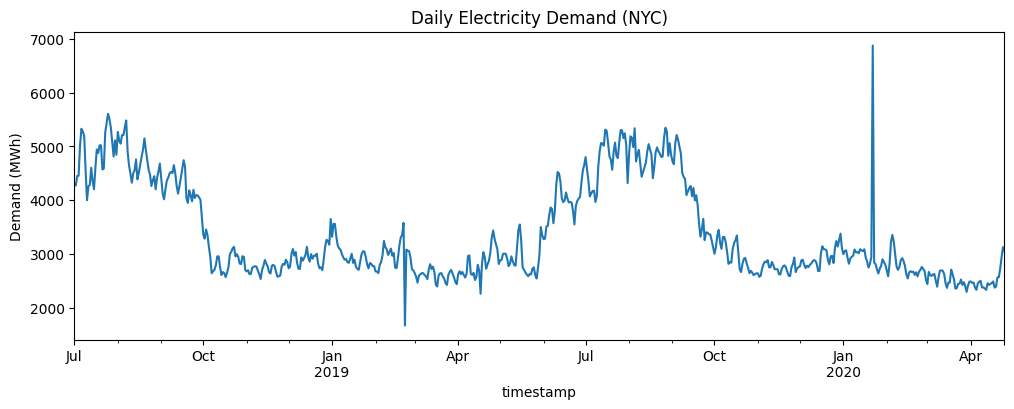

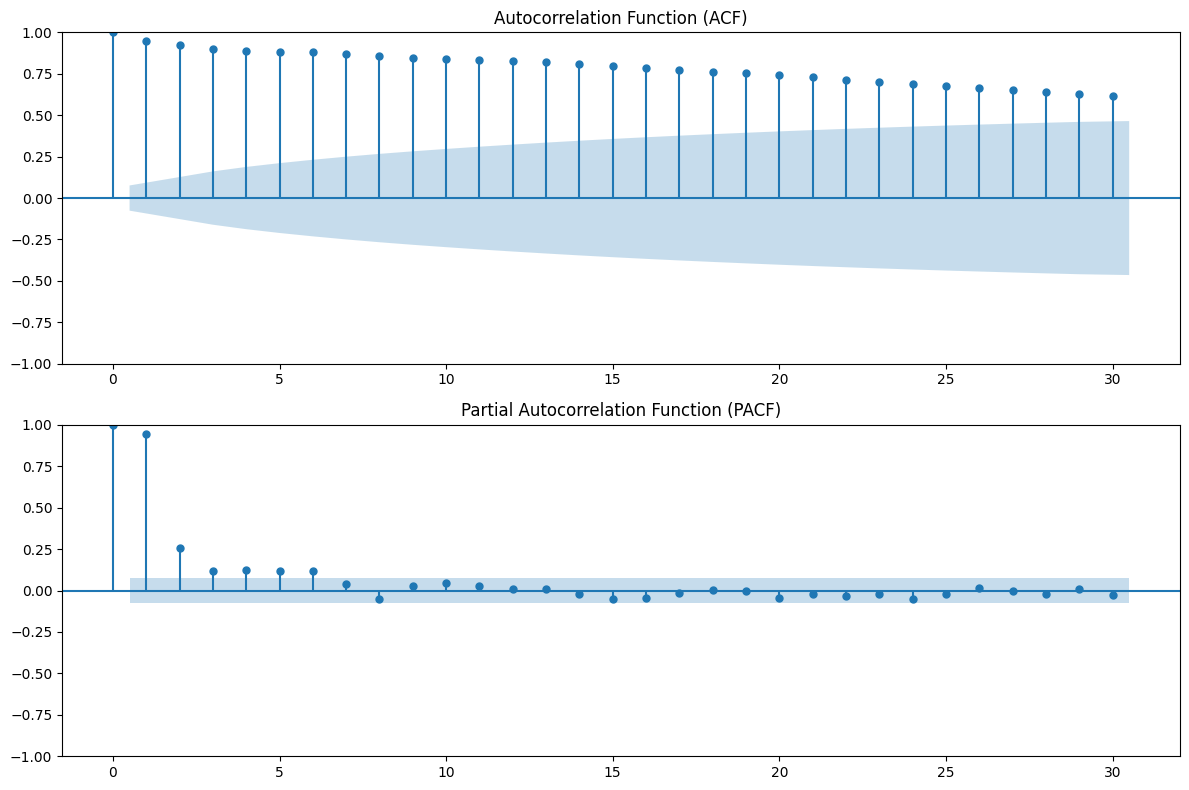

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  665
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4536.638
Date:                           Tue, 06 May 2025   AIC                           9085.276
Time:                                   14:07:24   BIC                           9112.120
Sample:                               07-01-2018   HQIC                          9095.690
                                    - 04-25-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3706      0.073      5.064      0.000       0.227       0.514
ar.L2          0.0592      0.043      1.384

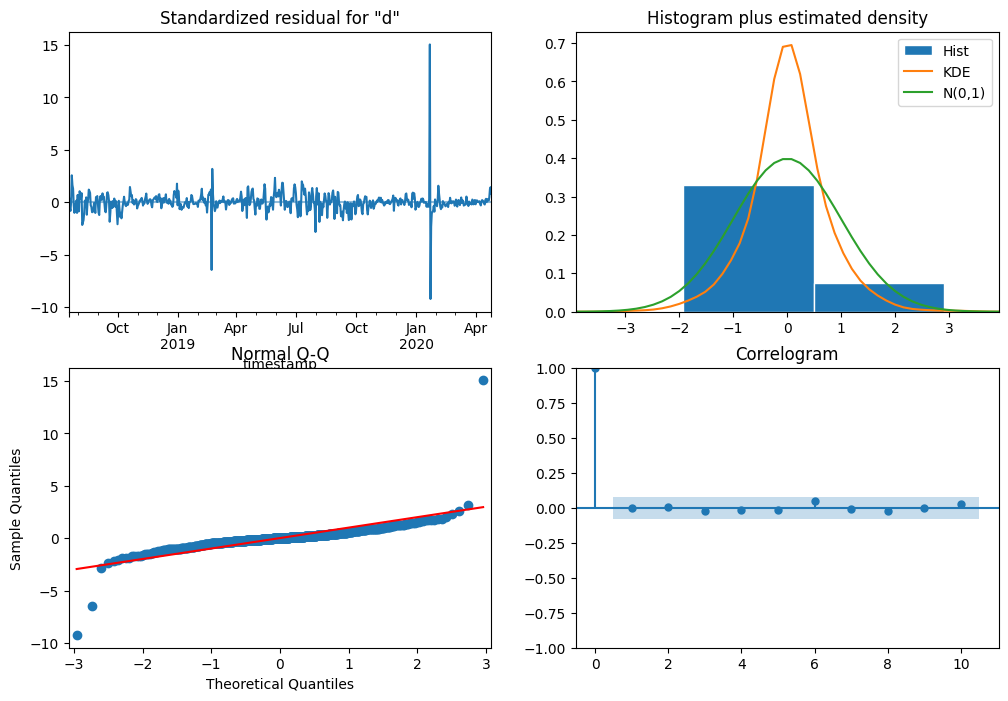

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  155.3445
RMSE: 338.9352
MAPE: 4.3818%
R2:   0.8528


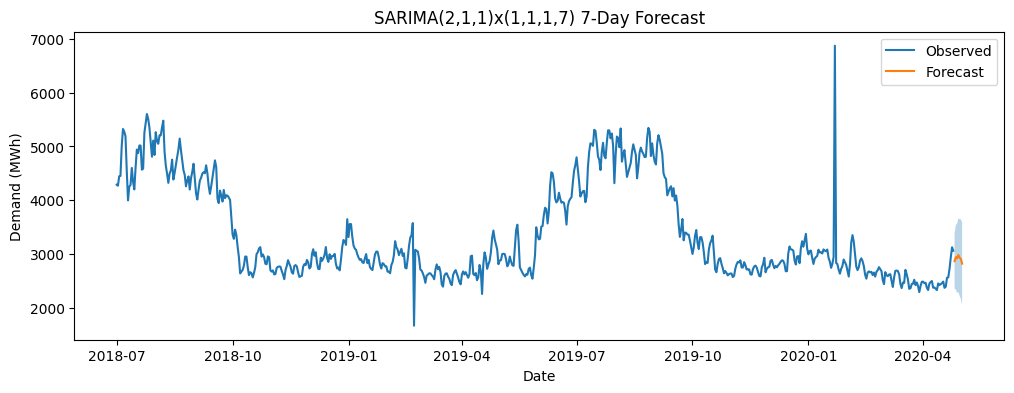

['model/sarima_phoenix_daily.pkl']

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., phoenix daily demand)
series = data[data['city']=='phoenix']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_phoenix_daily.pkl')

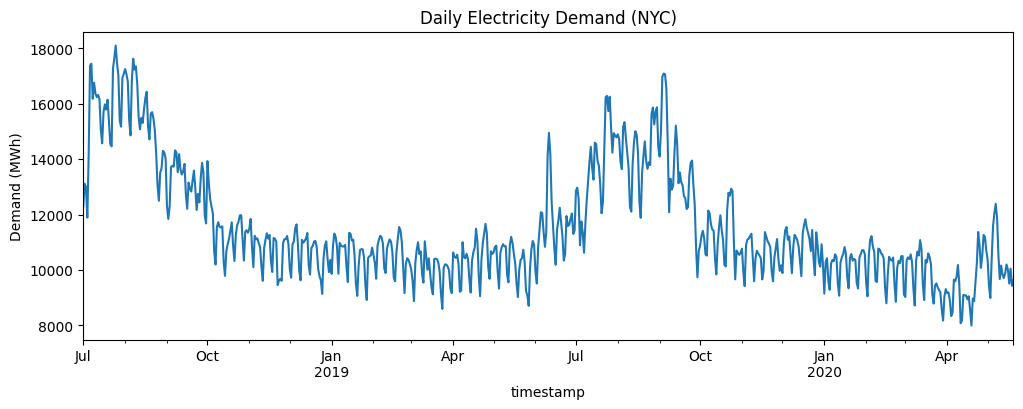

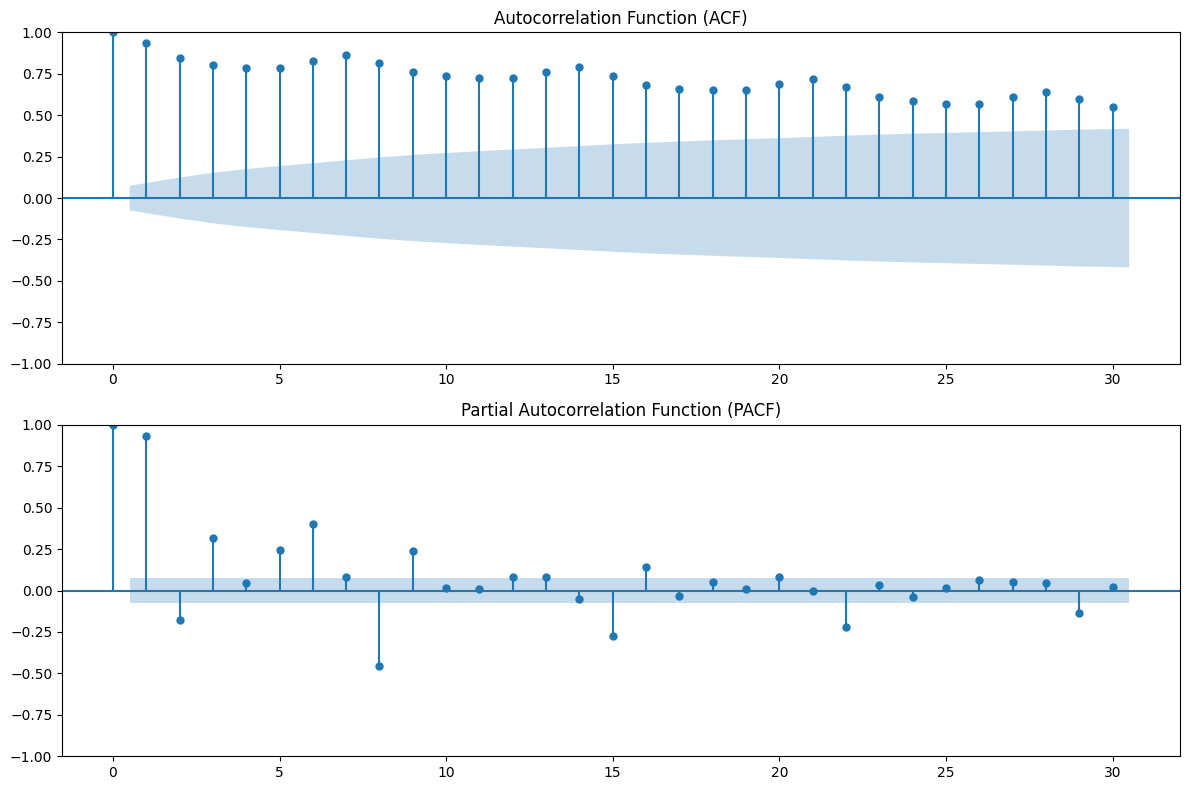

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  690
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5024.614
Date:                           Tue, 06 May 2025   AIC                          10061.228
Time:                                   13:38:30   BIC                          10088.298
Sample:                               07-01-2018   HQIC                         10071.711
                                    - 05-20-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0052      0.041     24.763      0.000       0.926       1.085
ar.L2         -0.3344      0.028    -12.136

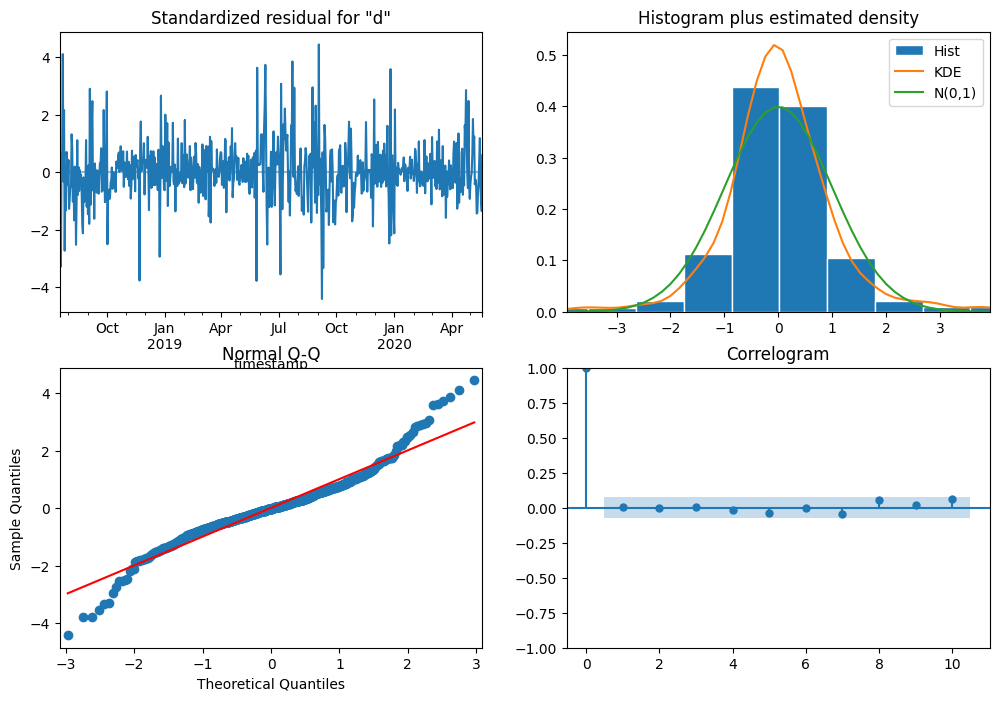

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  359.3463
RMSE: 800.1504
MAPE: 2.9840%
R2:   0.8469


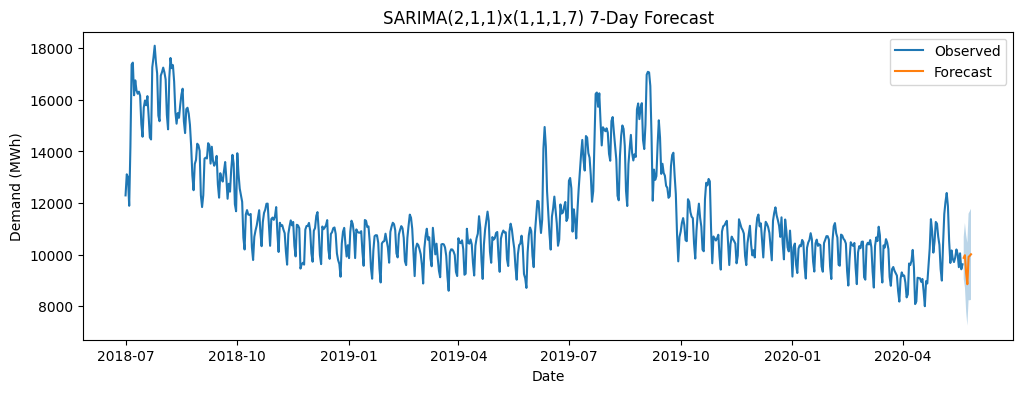

['model/sarima_la_daily.pkl']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., NYC daily demand)
series = data[data['city']=='la']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_la_daily.pkl')


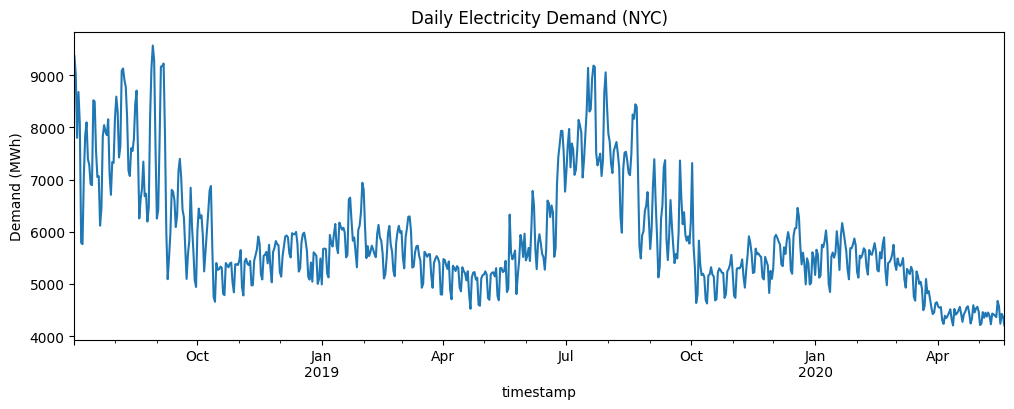

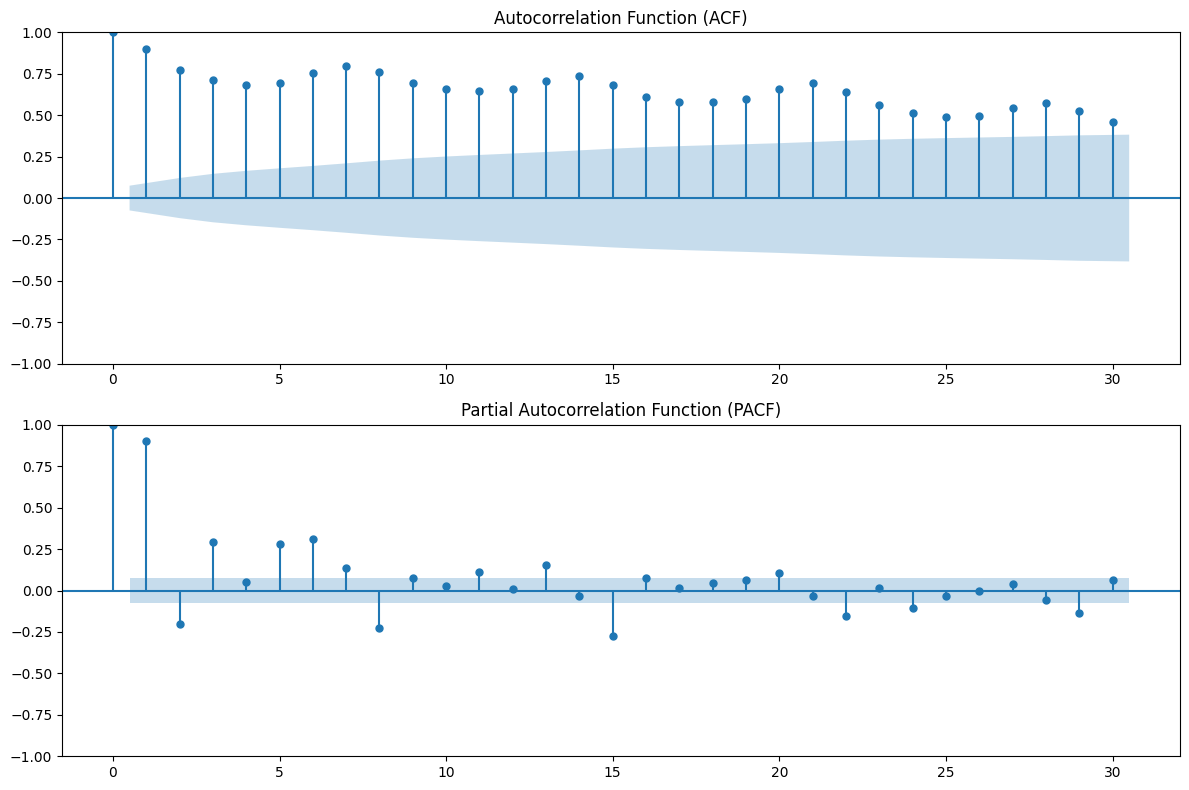

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  689
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4795.913
Date:                           Tue, 06 May 2025   AIC                           9603.827
Time:                                   13:39:46   BIC                           9630.888
Sample:                               07-02-2018   HQIC                          9614.307
                                    - 05-20-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8846      0.036     24.545      0.000       0.814       0.955
ar.L2         -0.3783      0.028    -13.525

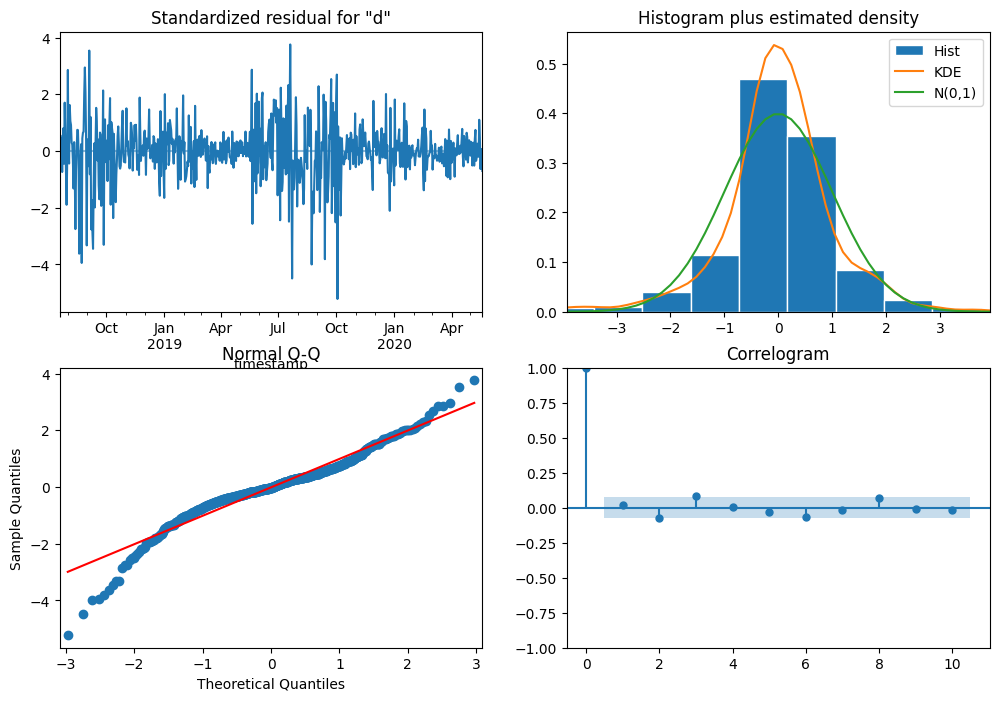

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  255.6791
RMSE: 553.7811
MAPE: 4.0426%
R2:   0.7405


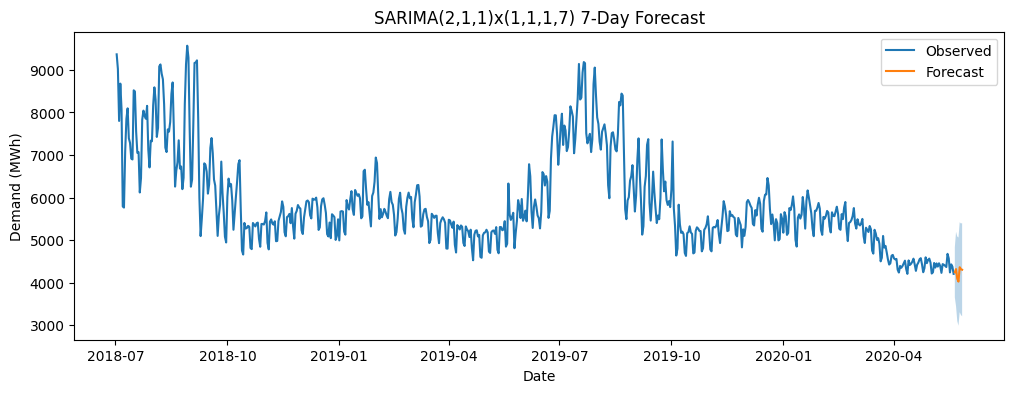

['model/sarima_nyc_daily.pkl']

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., phoenix daily demand)
series = data[data['city']=='nyc']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_nyc_daily.pkl')


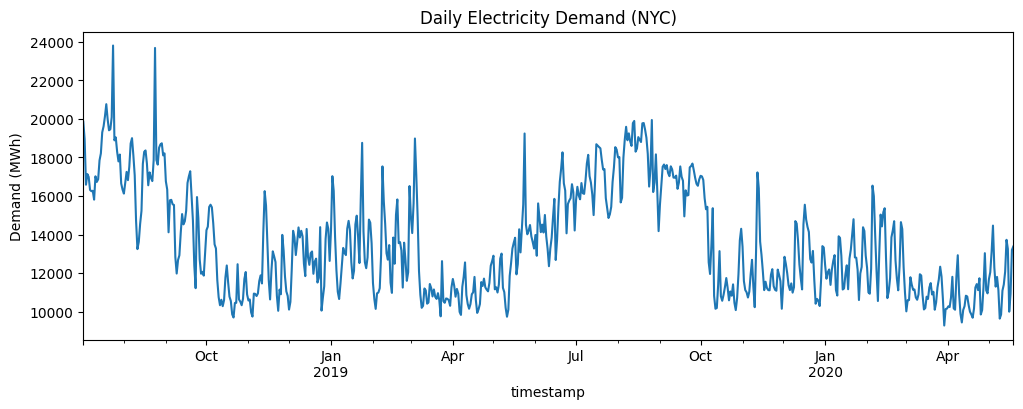

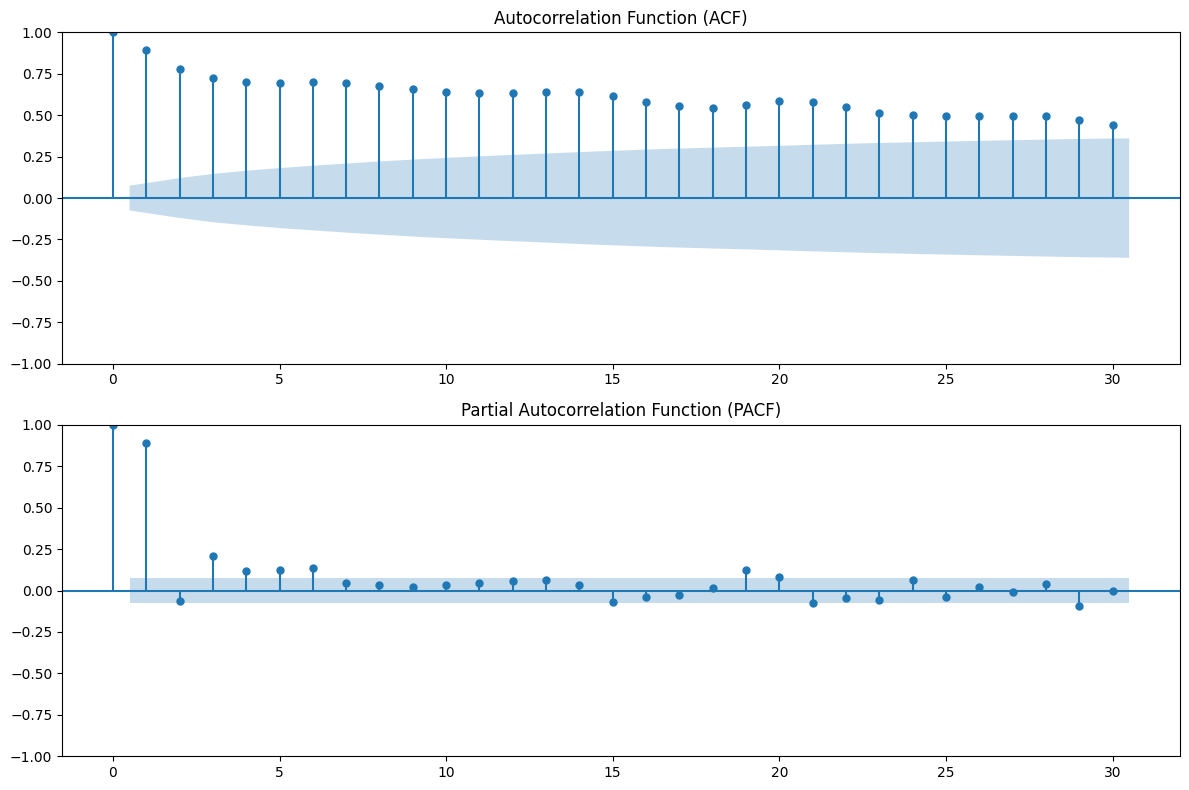

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  688
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5705.322
Date:                           Tue, 06 May 2025   AIC                          11422.644
Time:                                   13:40:36   BIC                          11449.697
Sample:                               07-02-2018   HQIC                         11433.122
                                    - 05-19-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7230      0.046     15.819      0.000       0.633       0.813
ar.L2         -0.2047      0.035     -5.918

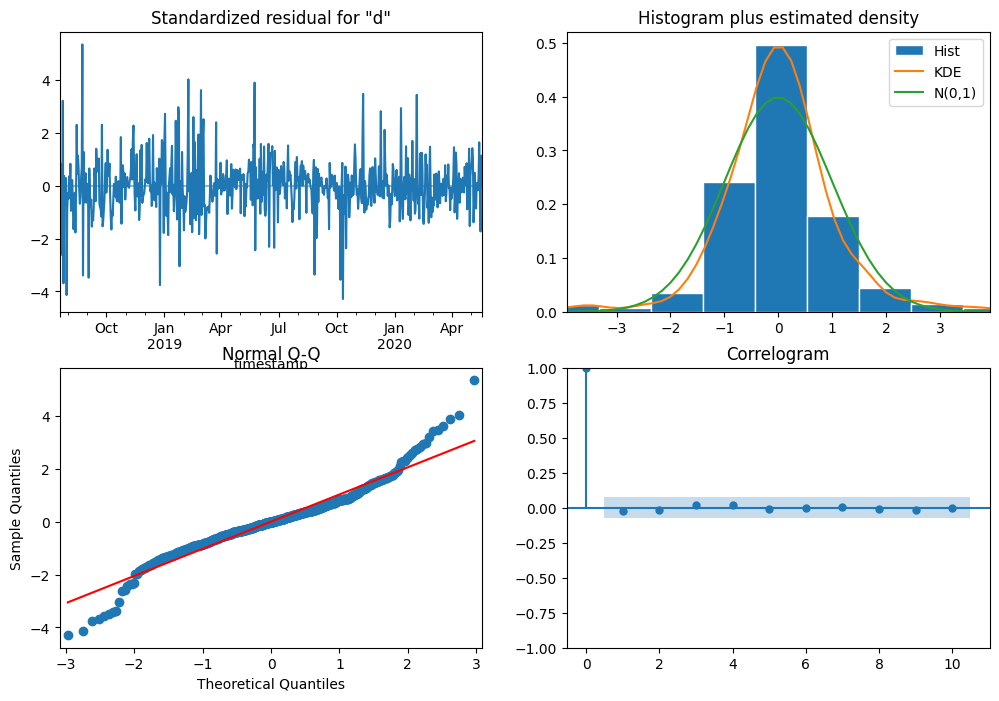

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  909.8572
RMSE: 1534.1677
MAPE: 6.5827%
R2:   0.6983


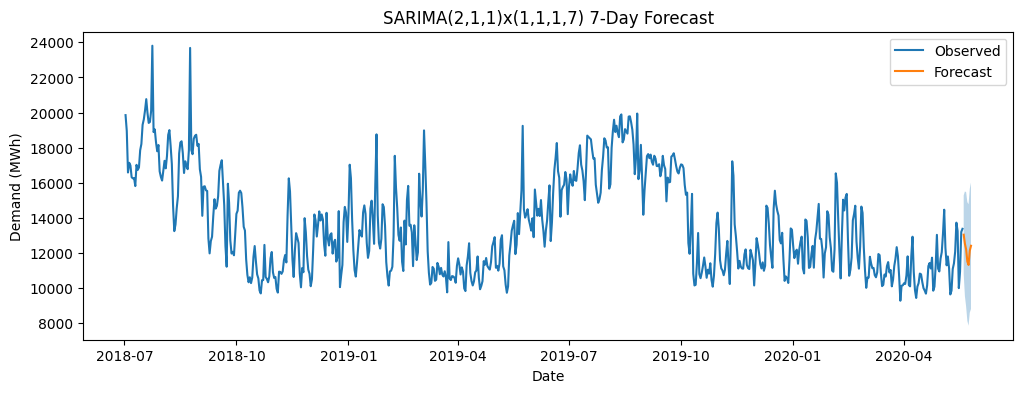

['model/sarima_dallas_daily.pkl']

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., dallas daily demand)
series = data[data['city']=='dallas']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_dallas_daily.pkl')


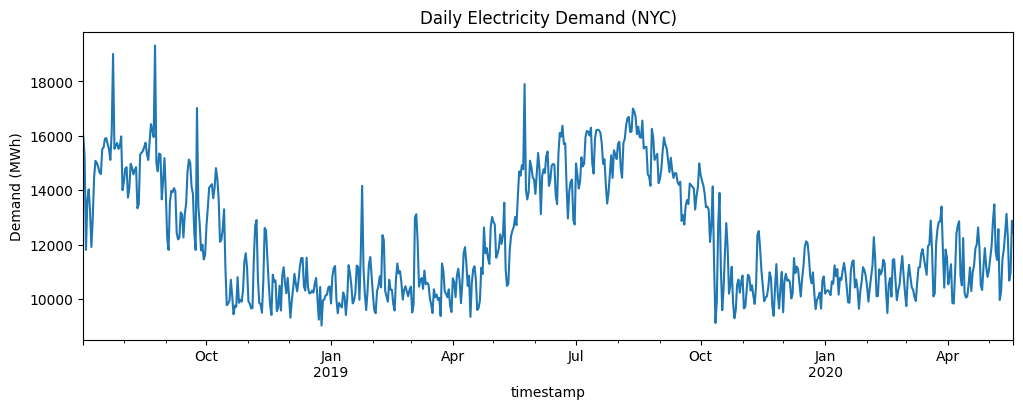

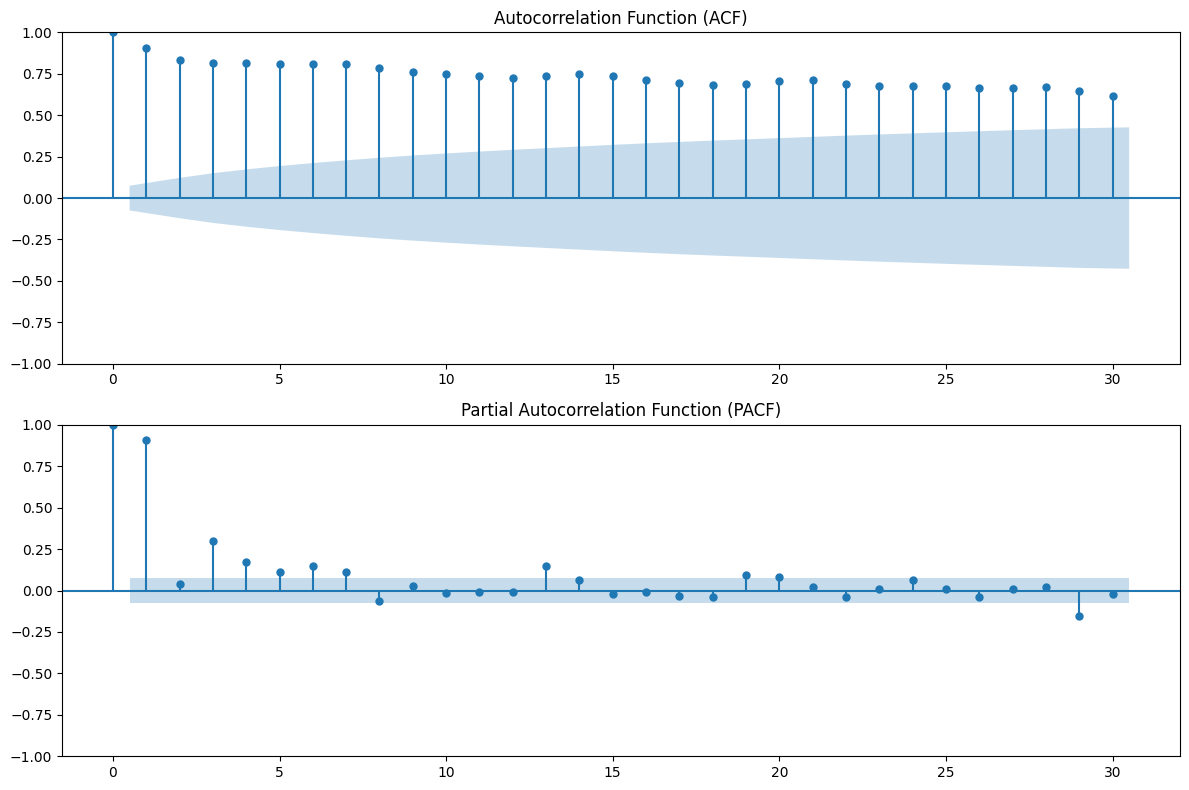

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  688
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5418.188
Date:                           Tue, 06 May 2025   AIC                          10848.375
Time:                                   14:10:12   BIC                          10875.428
Sample:                               07-02-2018   HQIC                         10858.853
                                    - 05-19-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4314      0.057      7.508      0.000       0.319       0.544
ar.L2         -0.2231      0.036     -6.184

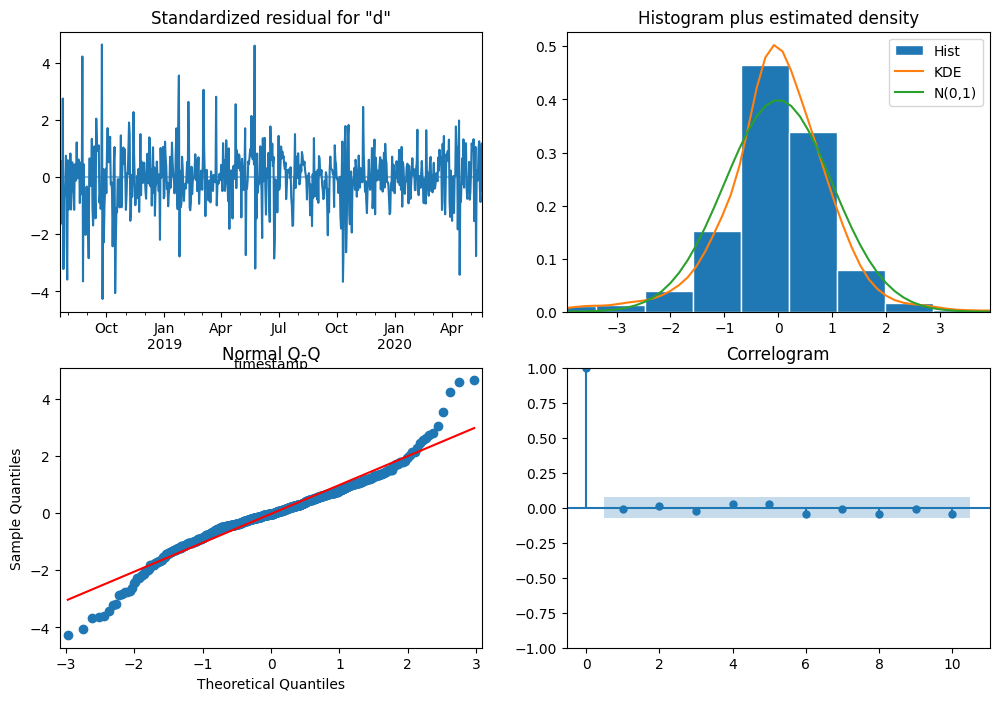

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  609.8086
RMSE: 1083.1707
MAPE: 4.9320%
R2:   0.7394


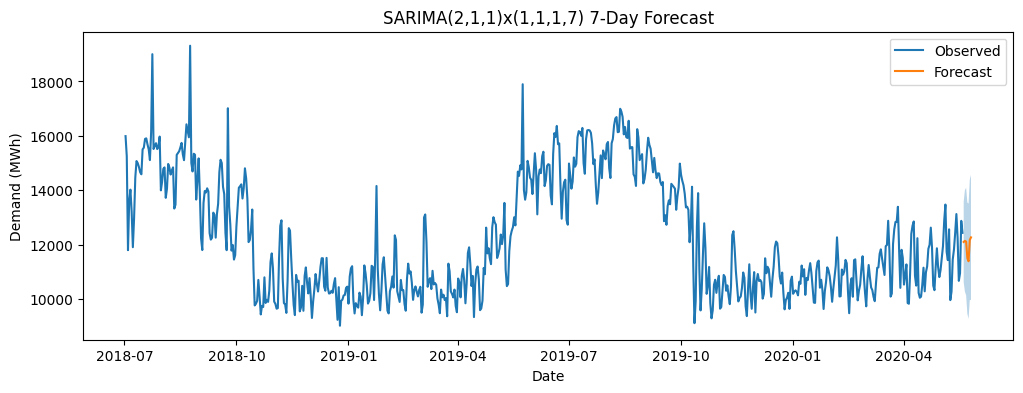

['model/sarima_houston_daily.pkl']

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., phoenix daily demand)
series = data[data['city']=='houston']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_houston_daily.pkl')


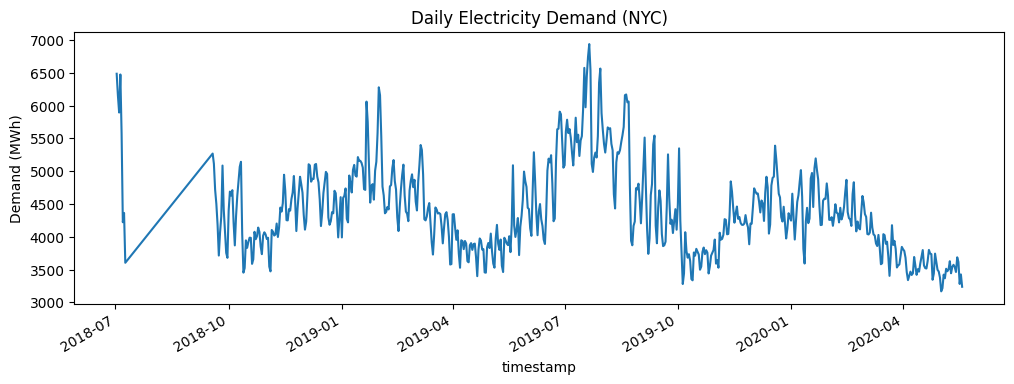

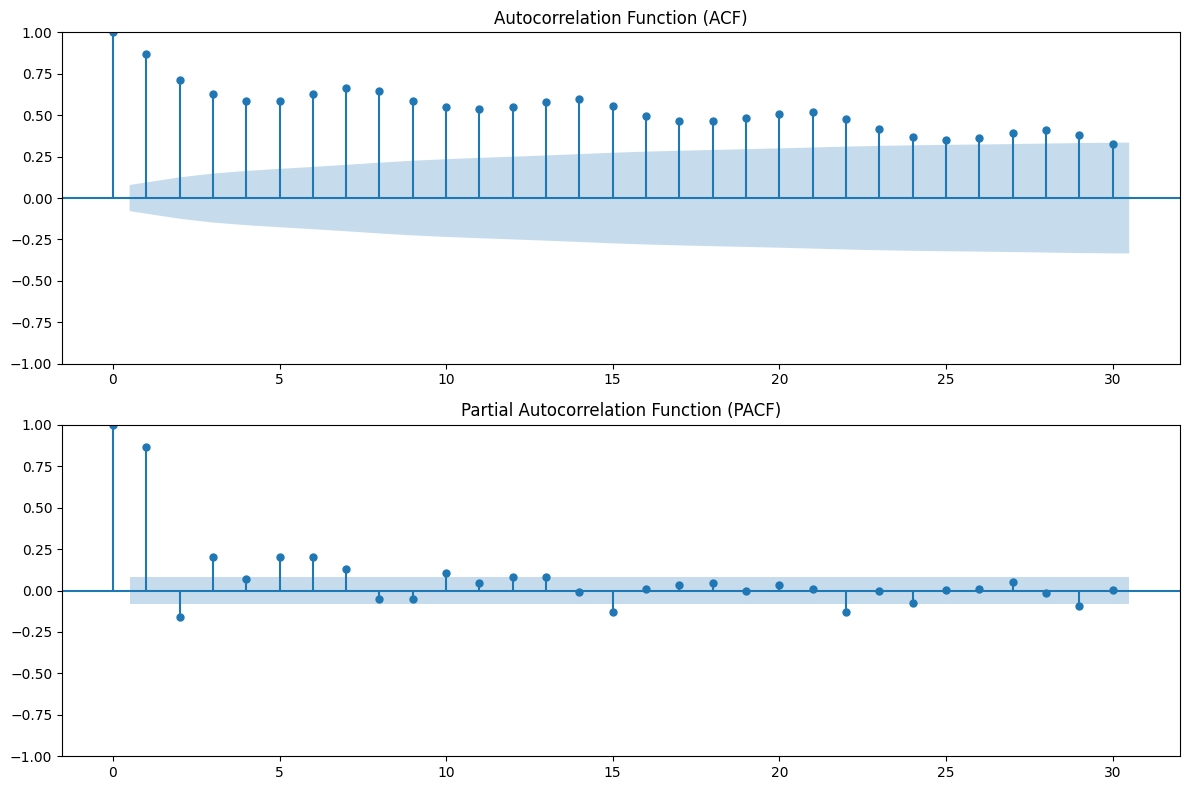

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  618
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4205.126
Date:                           Tue, 06 May 2025   AIC                           8422.252
Time:                                   14:10:59   BIC                           8448.643
Sample:                                        0   HQIC                          8432.525
                                           - 618                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8626      0.044     19.826      0.000       0.777       0.948
ar.L2         -0.3192      0.033     -9.599

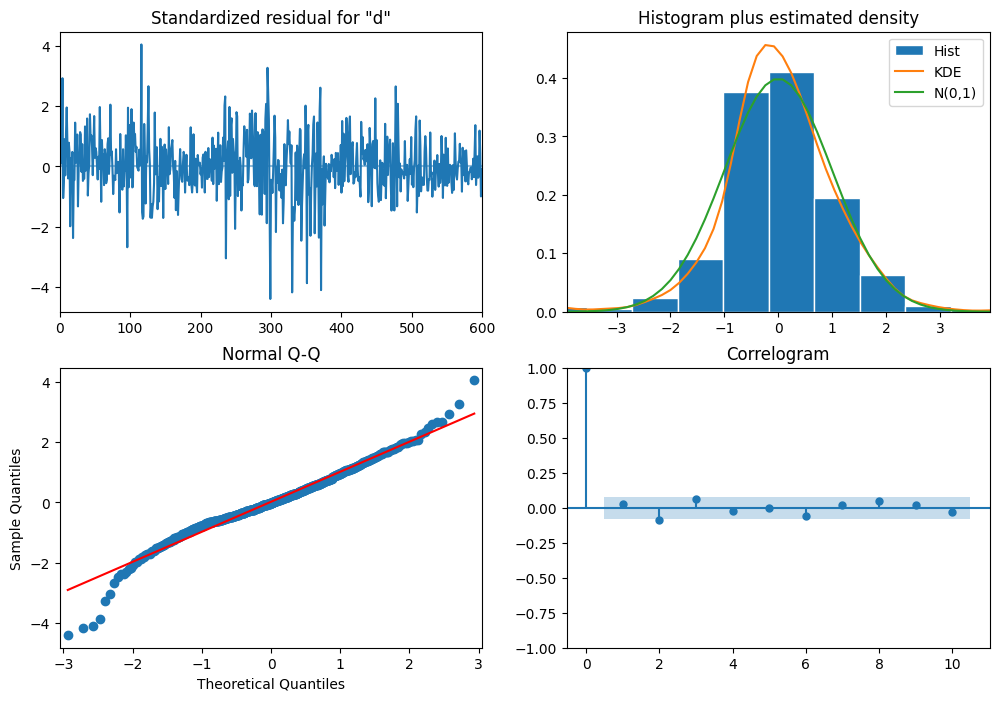

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  241.3158
RMSE: 488.3987
MAPE: 5.3184%
R2:   0.4736


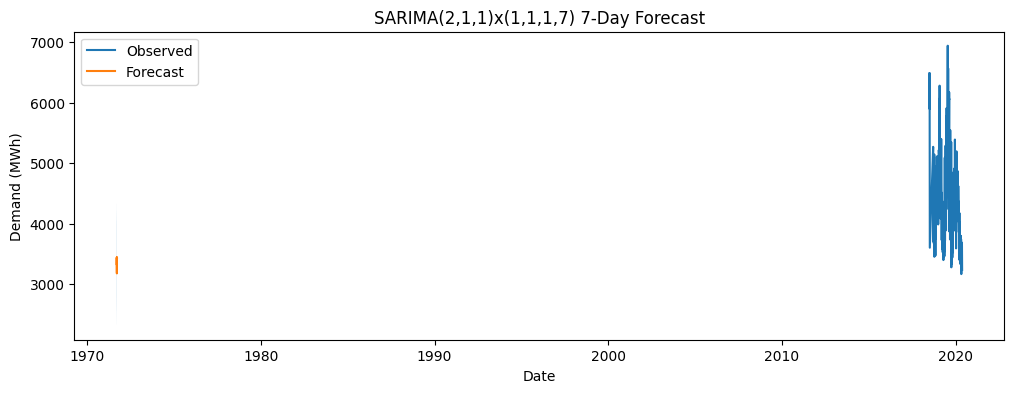

['model/sarima_philadelphia_daily.pkl']

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., phoenix daily demand)
series = data[data['city']=='philadelphia']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_philadelphia_daily.pkl')


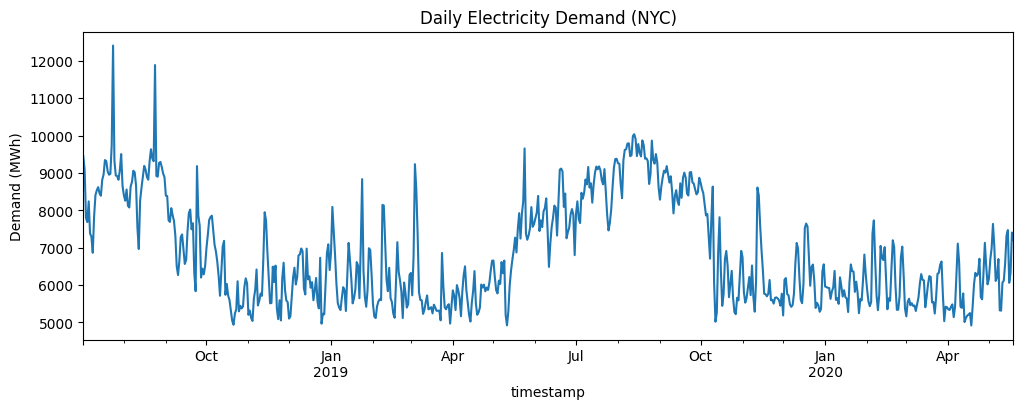

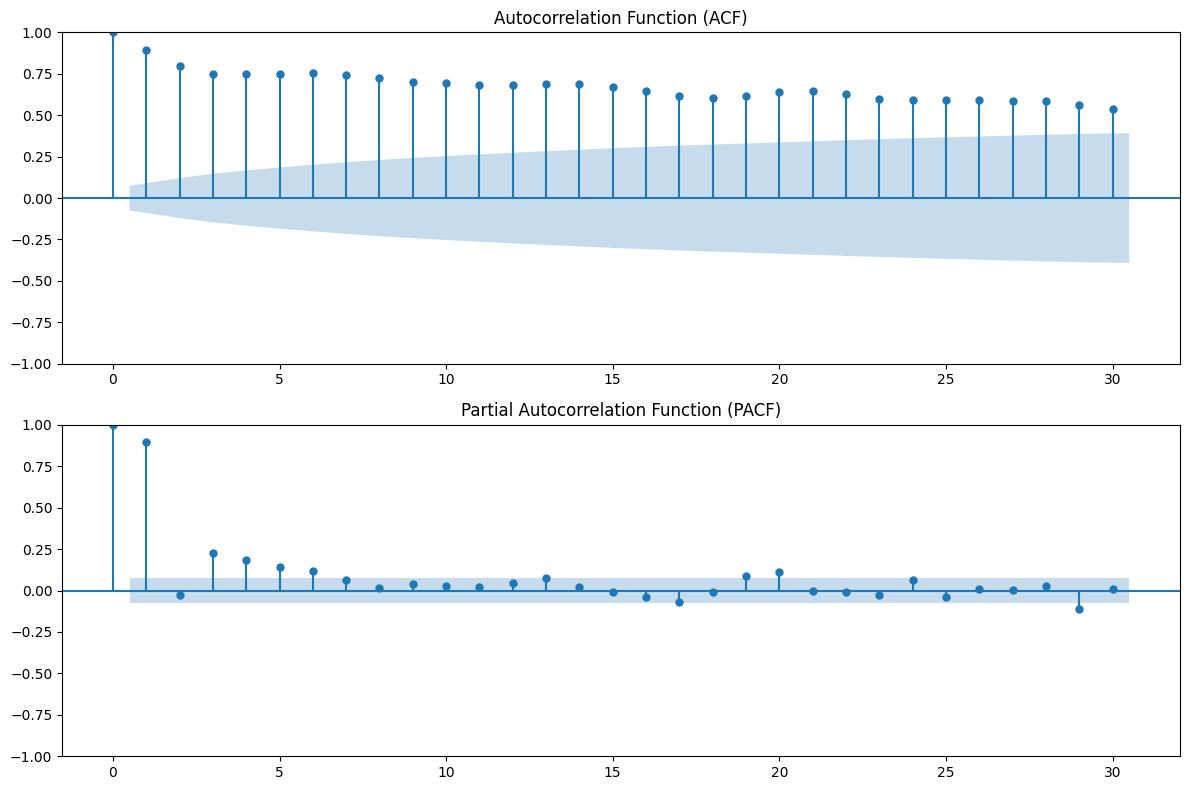

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  688
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5206.130
Date:                           Tue, 06 May 2025   AIC                          10424.261
Time:                                   14:12:58   BIC                          10451.314
Sample:                               07-02-2018   HQIC                         10434.739
                                    - 05-19-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5957      0.050     11.945      0.000       0.498       0.693
ar.L2         -0.2257      0.042     -5.420

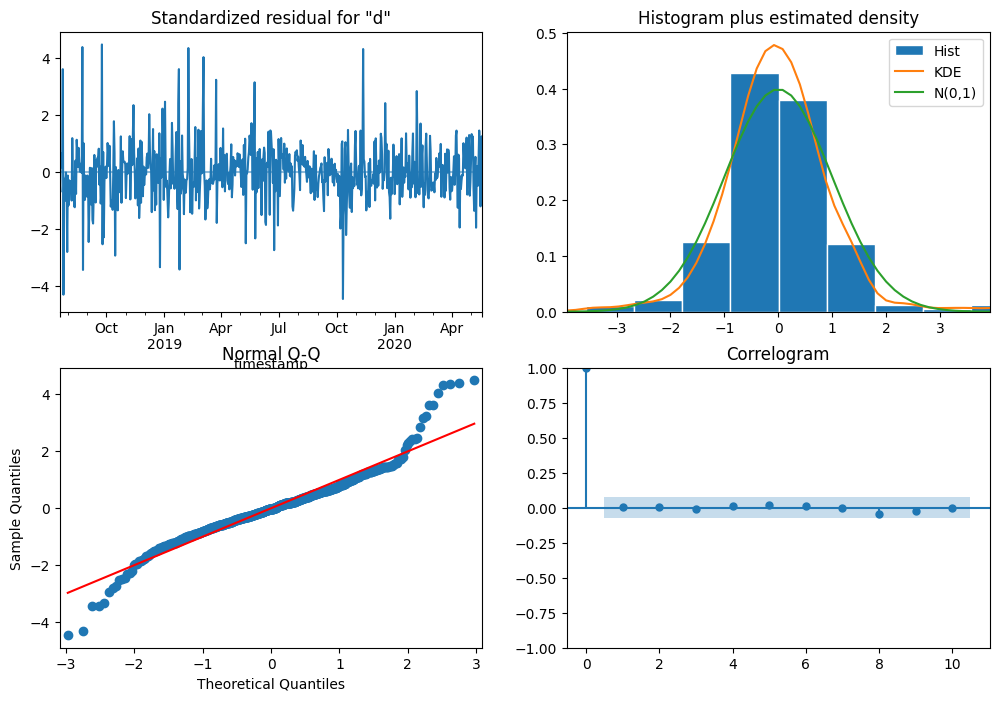

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  435.5215
RMSE: 732.9877
MAPE: 6.3649%
R2:   0.7227


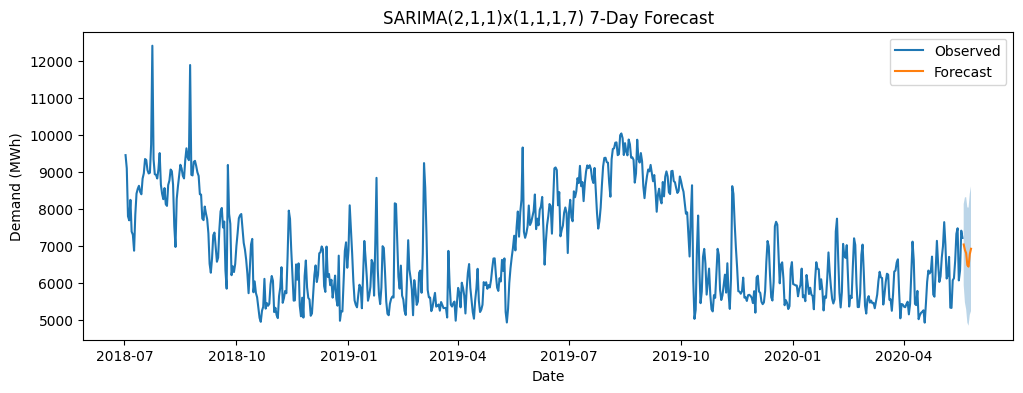

['model/sarima_san_antonio_daily.pkl']

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., phoenix daily demand)
series = data[data['city']=='san antonio']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_san_antonio_daily.pkl')


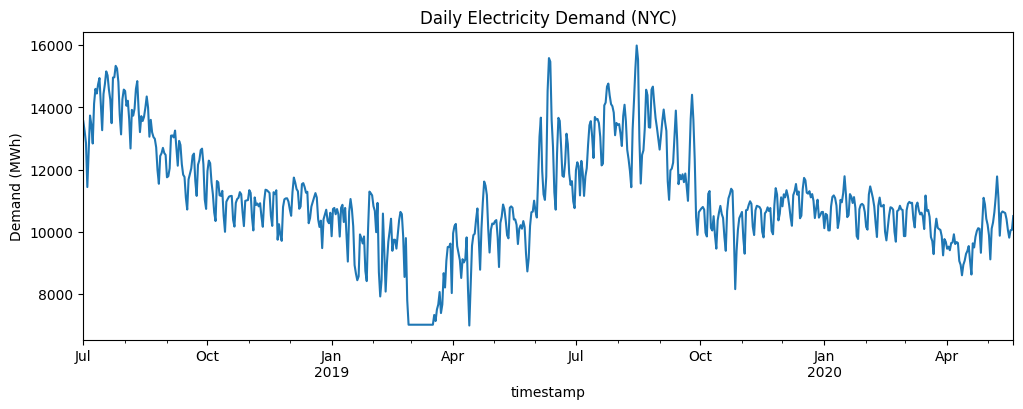

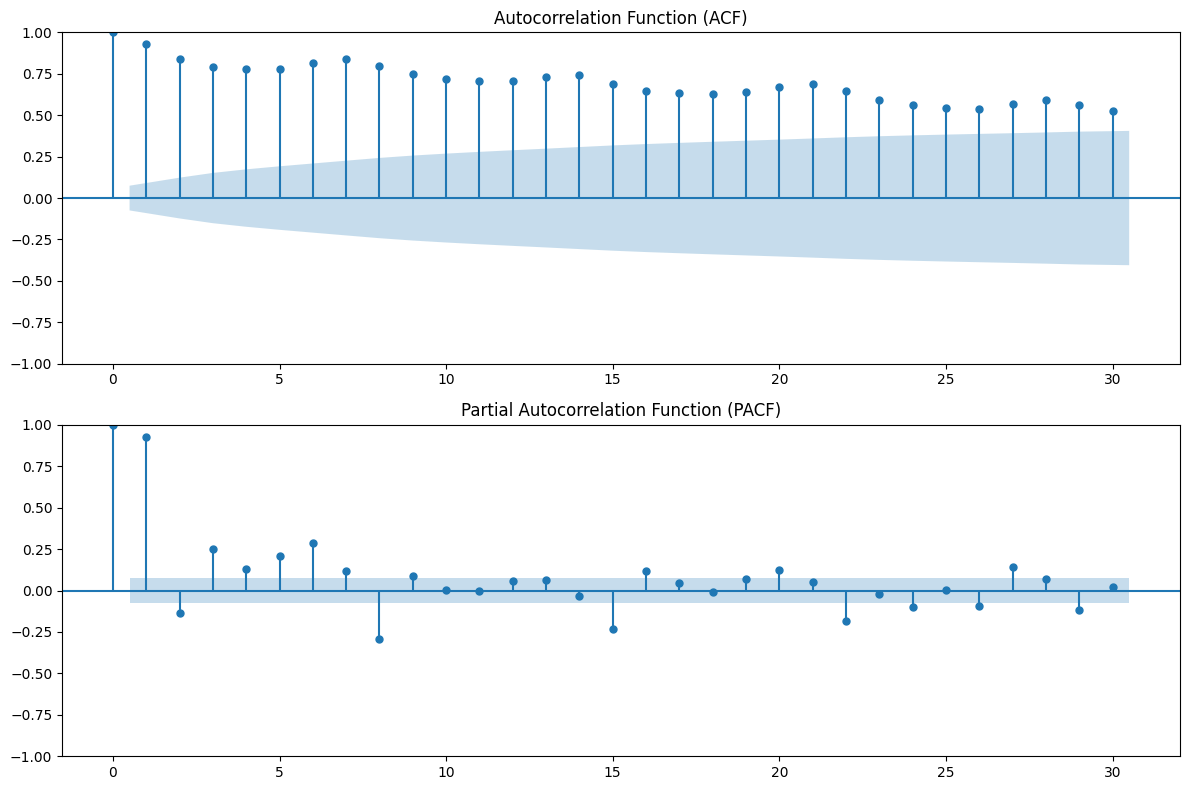

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  690
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5084.296
Date:                           Tue, 06 May 2025   AIC                          10180.593
Time:                                   14:13:52   BIC                          10207.663
Sample:                               07-01-2018   HQIC                         10191.076
                                    - 05-20-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8122      0.052     15.735      0.000       0.711       0.913
ar.L2         -0.2934      0.029    -10.182

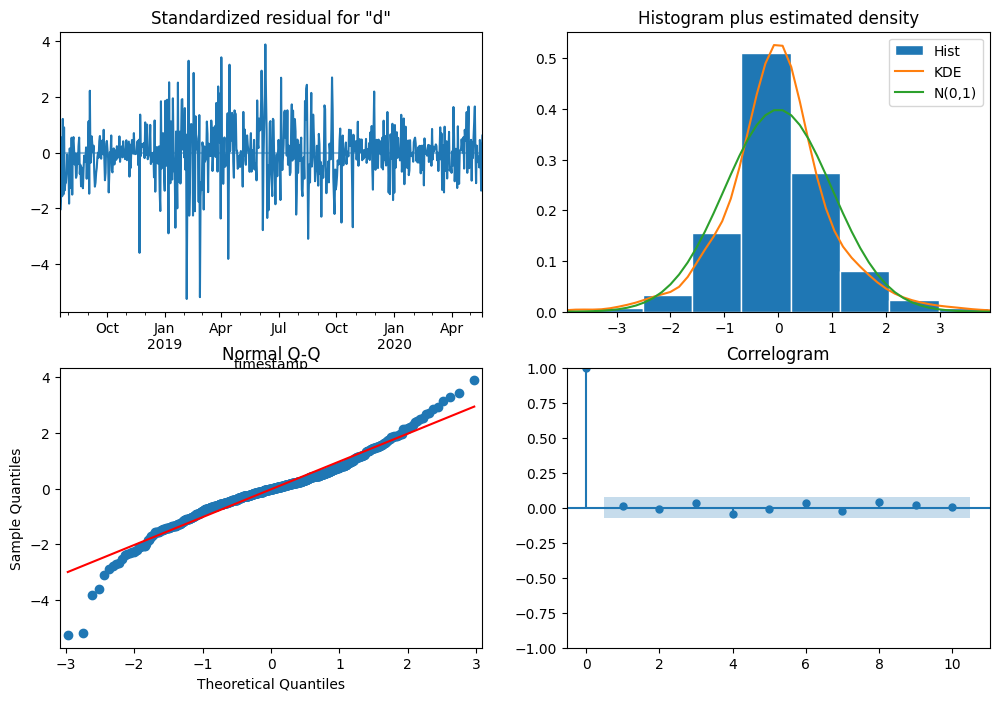

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  381.1277
RMSE: 826.9324
MAPE: 3.4336%
R2:   0.7633


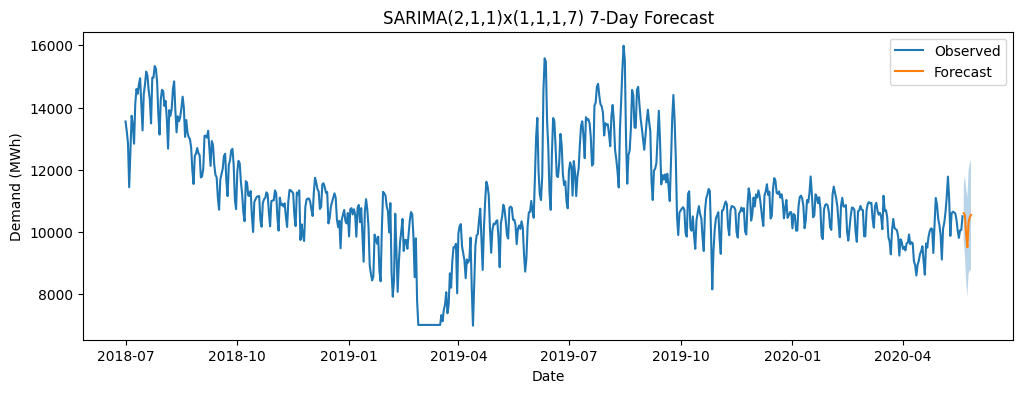

['model/sarima_san_jose_daily.pkl']

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., phoenix daily demand)
series = data[data['city']=='san jose']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_san_jose_daily.pkl')


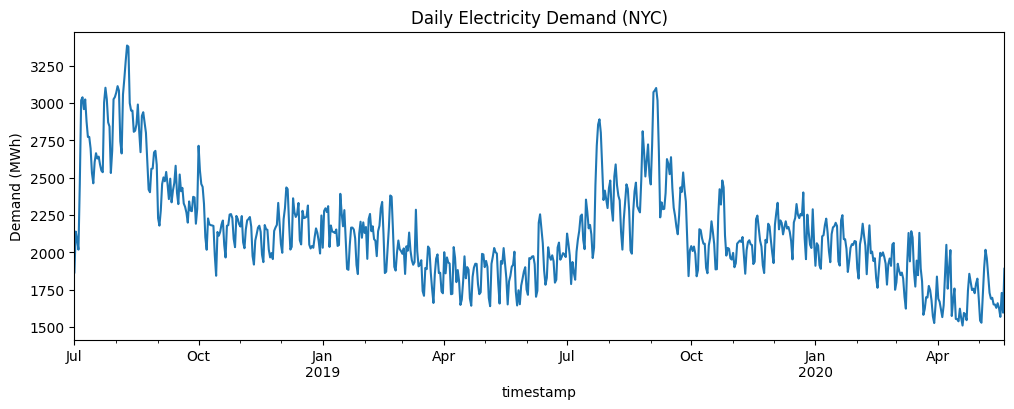

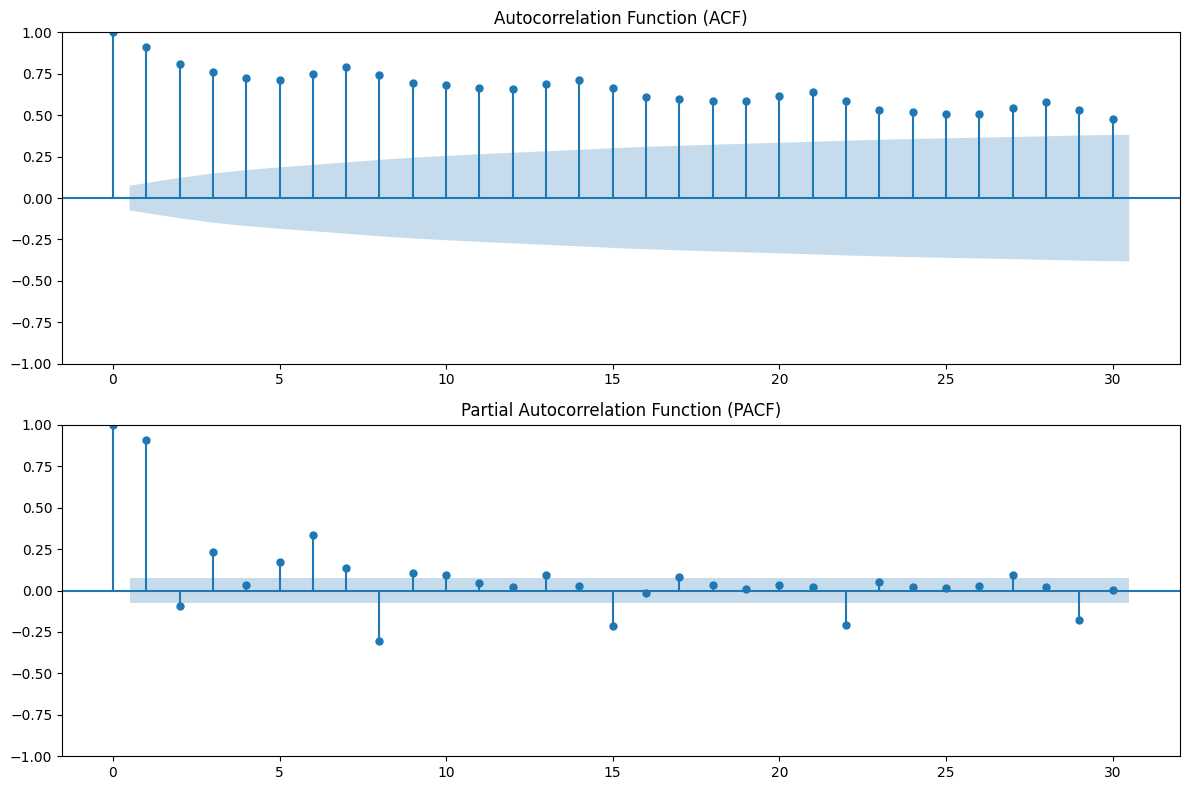

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  690
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4037.587
Date:                           Tue, 06 May 2025   AIC                           8087.174
Time:                                   14:14:27   BIC                           8114.244
Sample:                               07-01-2018   HQIC                          8097.657
                                    - 05-20-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8245      0.041     20.221      0.000       0.745       0.904
ar.L2         -0.1652      0.035     -4.704

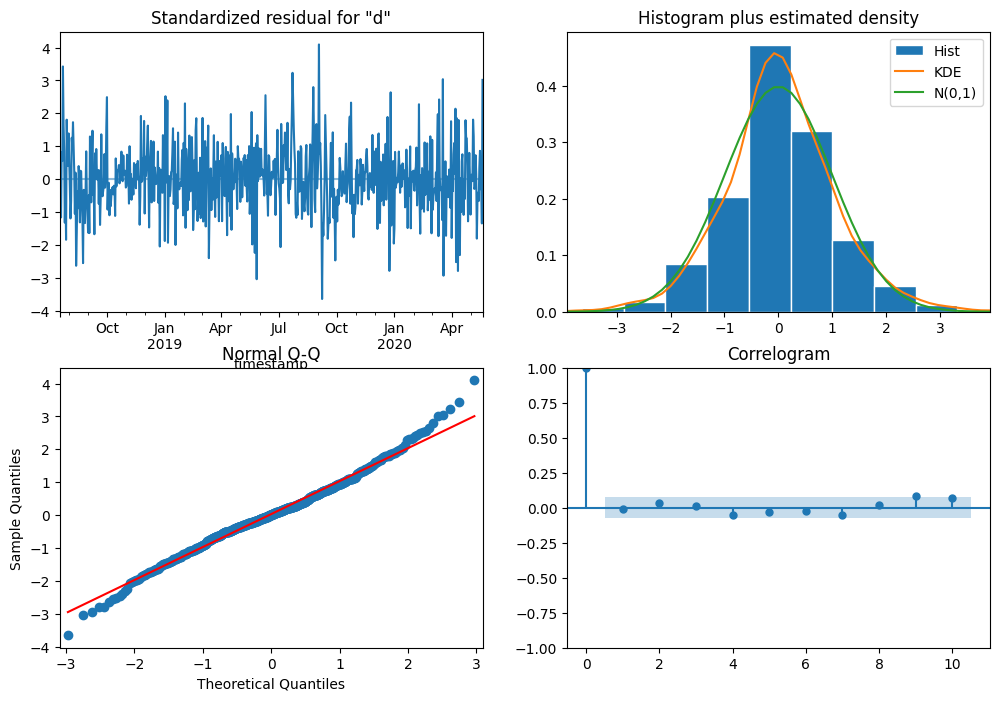

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  82.1875
RMSE: 138.7749
MAPE: 3.8227%
R2:   0.8221


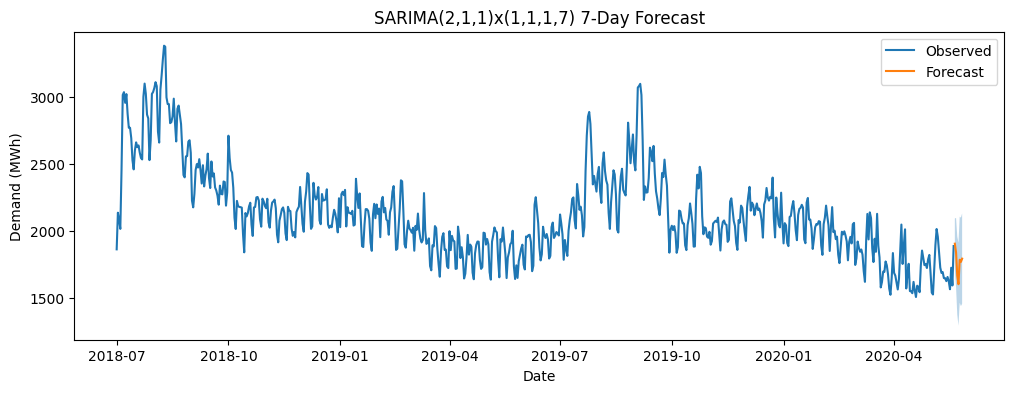

['model/sarima_san_diego_daily.pkl']

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., phoenix daily demand)
series = data[data['city']=='san diego']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_san_diego_daily.pkl')


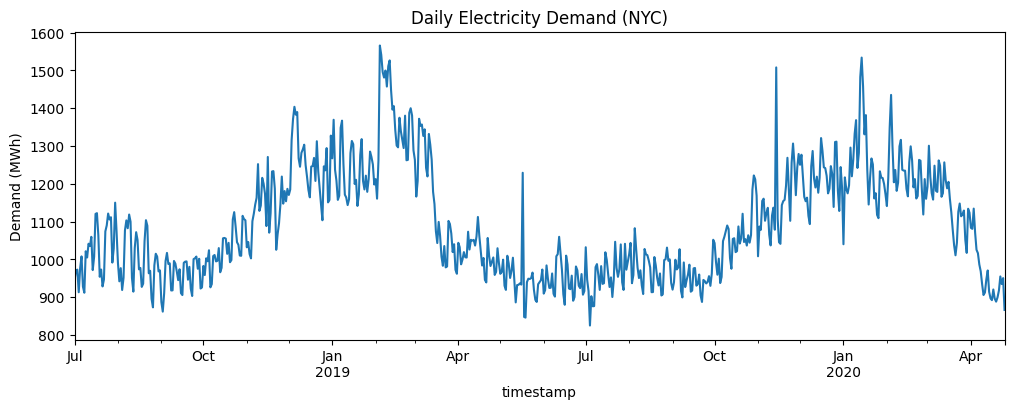

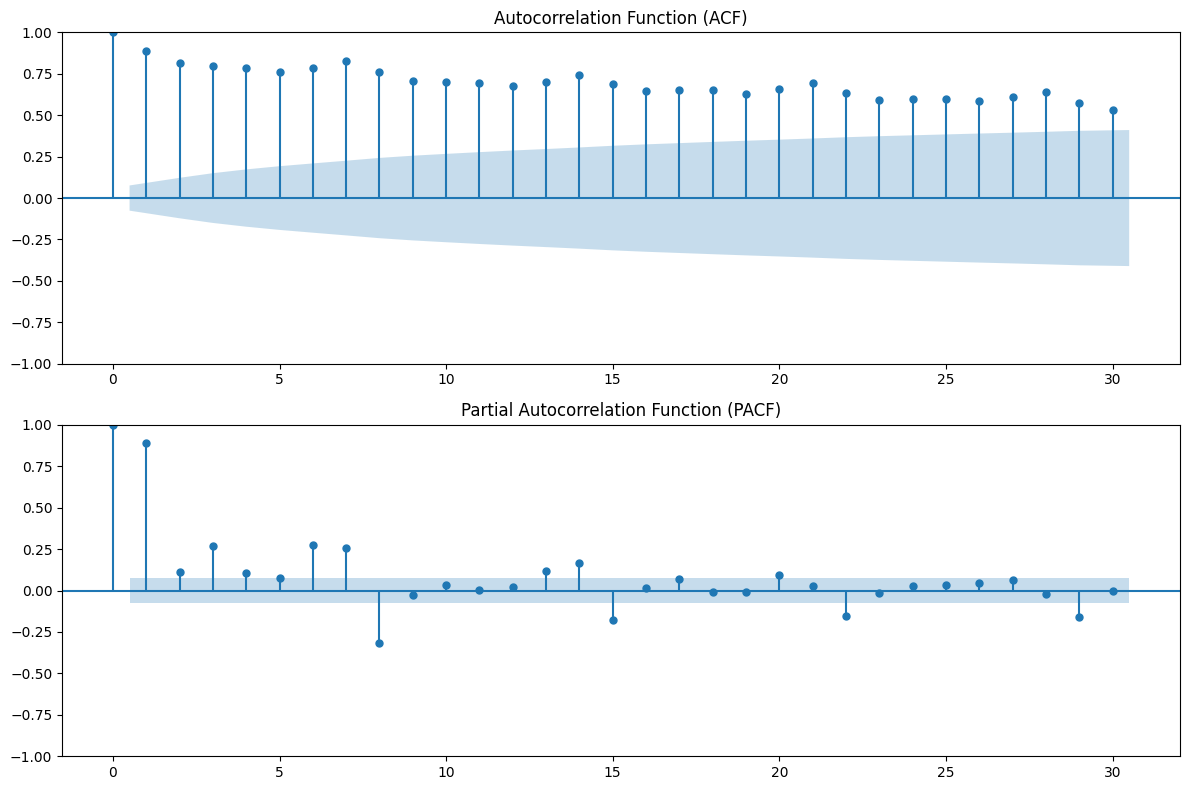

                                     SARIMAX Results                                     
Dep. Variable:                        demand_mwh   No. Observations:                  665
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3446.625
Date:                           Tue, 06 May 2025   AIC                           6905.250
Time:                                   14:14:56   BIC                           6932.094
Sample:                               07-01-2018   HQIC                          6915.664
                                    - 04-25-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5721      0.054     10.662      0.000       0.467       0.677
ar.L2         -0.0279      0.045     -0.622

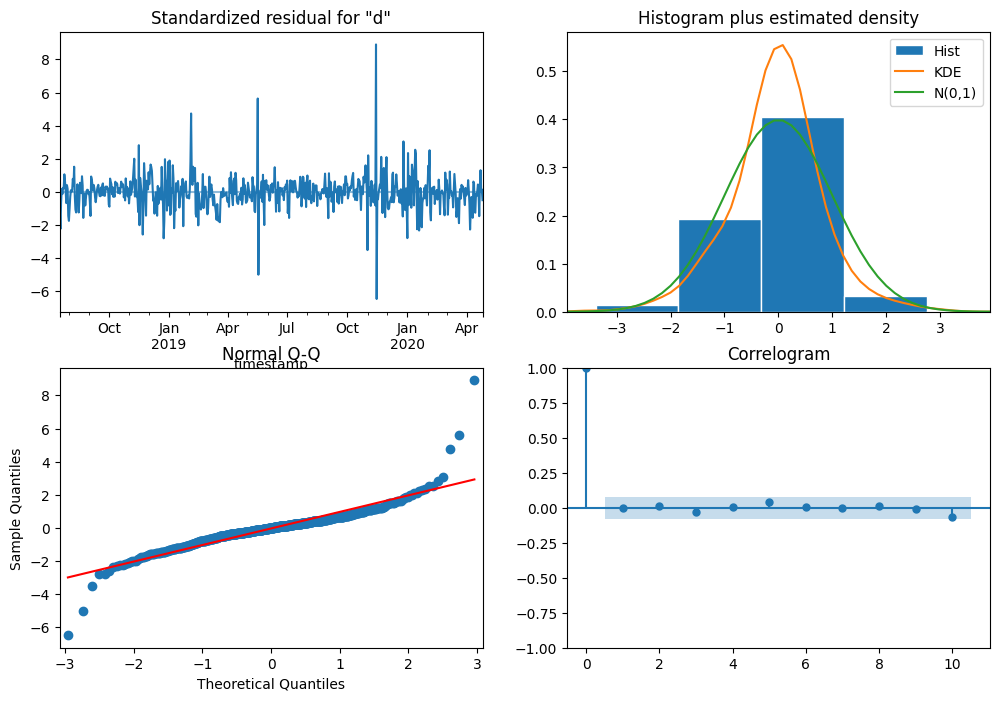

SARIMA(2,1,1)x(1,1,1,7) In-Sample Performance Metrics:
MAE:  35.7224
RMSE: 67.4989
MAPE: 3.2727%
R2:   0.7832


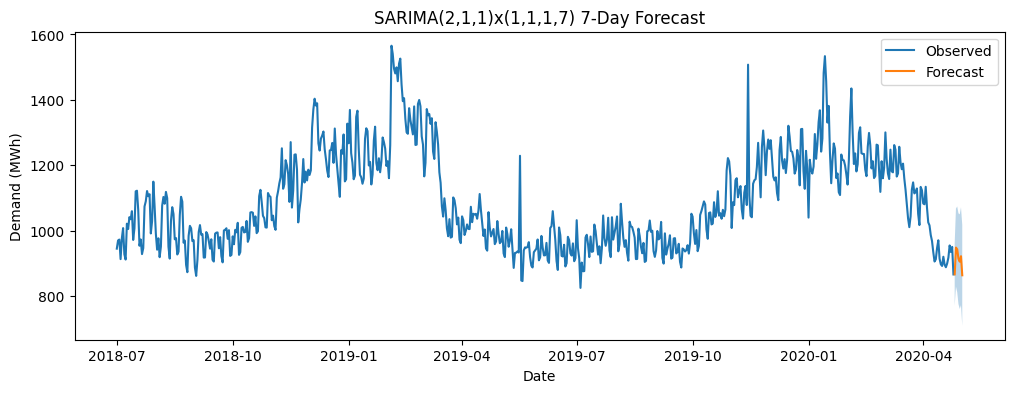

['model/sarima_seattle_daily.pkl']

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import joblib

# 1. Load preprocessed data
#    Daily aggregated demand for one city
data = pd.read_csv(
    'data/preprocessed_and_cleaned_data.csv',
    parse_dates=['timestamp'],
    index_col='timestamp'
)

# 2. Select series (e.g., phoenix daily demand)
series = data[data['city']=='seattle']['demand_mwh']
daily_series = series.resample('D').mean().dropna()

# 3. Plot the raw series
daily_series.plot(figsize=(12,4), title='Daily Electricity Demand (NYC)')
plt.ylabel('Demand (MWh)')
plt.show()

# 4. Plot ACF and PACF to estimate ARIMA parameters
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(daily_series, lags=30, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(daily_series, lags=30, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

# 5. Set SARIMA(p,d,q)(P,D,Q,s) based on ACF/PACF inspection
#    ACF shows exponential decay, PACF significant at lag1 & lag2
#    Hence choose non-seasonal p=2, d=1, q=1; seasonal P=1, D=1, Q=1, s=7
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 7

# 6. Fit SARIMA model
model = SARIMAX(
    daily_series,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)
clf = model.fit(disp=False)
print(clf.summary())

# 7. Diagnostic plots
clf.plot_diagnostics(figsize=(12,8))
plt.show()

# 8. In-sample predictions for error metrics
fitted = clf.fittedvalues.reindex(daily_series.index)

# 9. Compute evaluation metrics
mae = mean_absolute_error(daily_series, fitted)
mse = mean_squared_error(daily_series, fitted)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(daily_series, fitted)
r2 = r2_score(daily_series, fitted)

print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) In-Sample Performance Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R2:   {r2:.4f}")

# 10. Forecast next 7 days
forecast = clf.get_forecast(steps=7)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(
    mean_forecast.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title(f'SARIMA({p},{d},{q})x({P},{D},{Q},{s}) 7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.show()

# 11. Persist model
joblib.dump(clf, 'model/sarima_seattle_daily.pkl')


SyntaxError: invalid syntax (1256699264.py, line 83)